In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import zipfile
from datasets import Dataset
import pandas as pd
import pathlib

In [3]:
import sys
sys.path.append('..')
from scripts.audio import audio_array_to_wav_file
from scripts.ipa import timit2ipa

In [ ]:
timit = zipfile.ZipFile('../.data/TIMIT.zip', 'r')
timit_files = timit.namelist()
print(timit_files)

In [ ]:
# print PHONCODE.DOC 
timit_phoncode = timit.open('PHONCODE.DOC')
for line in timit_phoncode:
    print(line.decode('utf-8').strip())

In [ ]:
# print PROMPTS.TXT
timit_prompts = timit.open('PROMPTS.TXT')
for line in timit_prompts:
    print(line.decode('utf-8').strip())

In [ ]:
# print README.DOC
timit_readme = timit.open('README.DOC')
for line in timit_readme:
    print(line.decode('utf-8').strip())

In [ ]:
# print SPKRINFO.TXT
timit_spkrinfo = timit.open('SPKRINFO.TXT')
for line in timit_spkrinfo:
    print(line.decode('utf-8').strip())

In [9]:
REGIONS = ['New England', 'Northern', 'North Midland', 'South Midland', 'Southern', 'New York City', 'Western', 'Army Brat (moved around)']
records = []
for line in timit.open('SPKRINFO.TXT'):
    line = line.decode('utf-8').strip()
    if line == "" or line.startswith(';'):
        continue
    line = line.split()
    if len(line) < 10:
        line += [""] * (10 - len(line))
    records.append({
        "speaker_initials": line[0],
        "sex": line[1],
        "dialect_region": REGIONS[int(line[2]) - 1],
        "use": "Train" if line[3] == "TRN" else "Test",
        "recording_date": line[4],
        "birth_date": line[5],
        "height": line[6],
        "race": line[7],
        "education_level": line[8],
        "comments": line[9]
    })
speaker_info_df = pd.DataFrame(records)
speaker_info_df.head()

,speaker_initials,sex,dialect_region,use,recording_date,birth_date,height,race,education_level,comments
0,ABC0,M,New York City,Train,03/03/86,06/17/60,"5'11""",WHT,BS,
1,ABW0,M,Northern,Test,04/21/86,05/26/59,"5'9""",WHT,BS,
2,ADC0,M,North Midland,Train,02/25/86,04/27/54,"5'9""",WHT,HS,
3,ADD0,M,Western,Train,01/28/86,03/23/58,"6'2""",WHT,BS,
4,ADG0,F,South Midland,Test,02/12/86,04/11/59,"5'4""",WHT,MS,


In [ ]:
# print SPKRSENT.TXT
timit_spkrsent = timit.open('SPKRSENT.TXT')
for line in timit_spkrsent:
    print(line.decode('utf-8').strip())

In [ ]:
# print TESTSET.DOC
timit_testset = timit.open('TESTSET.DOC')
for line in timit_testset:
    print(line.decode('utf-8').strip())

In [ ]:
# print TIMITDIC.DOC
timit_timitdic = timit.open('TIMITDIC.DOC')
for line in timit_timitdic:
    print(line.decode('utf-8').strip())

In [ ]:
# print TIMITDIC.TXT
timit_timitdic = timit.open('TIMITDIC.TXT')
for line in timit_timitdic:
    print(line.decode('utf-8').strip())

In [ ]:
# list the file extensions for each data point
set(map(lambda x: x.split('.')[1], filter(lambda x: x.startswith('data/TRAIN'), timit_files)))

In [ ]:
training_files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/TRAIN'), timit_files))))
print(training_files)

In [ ]:
test_files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/TEST'), timit_files))))
print(test_files)

In [38]:
def timit_file_to_dict(filename):
    with timit.open(filename + '.PHN') as phn_file:
        timestamped_phonemes = []
        for line in phn_file.read().decode('utf-8').split('\n'):
            if line == '':
                continue
            start, end, phoneme = line.split()
            timestamped_phonemes.append((timit2ipa(phoneme), int(start) / 16_000, int(end) / 16_000))
    with timit.open(filename + '.TXT') as txt_file:
        transcription = txt_file.read().decode('utf-8').strip()
        # first two numbers are the start and end times
        transcription_start, transcription_end, *words = transcription.split()
        transcription = ' '.join(words)
    with timit.open(filename + '.WRD') as wrd_file:
        timestamped_words = []
        for line in wrd_file.read().decode('utf-8').split('\n'):
            if line == '':
                continue
            start, end, word = line.split()
            timestamped_words.append((word, int(start) / 16_000, int(end) / 16_000))
    path_segments = pathlib.Path(filename).parts
    speaker_initials = path_segments[-2][1:]
    return {'speaker_initials': speaker_initials, 'timestamped_phonemes': timestamped_phonemes, 'transcription': transcription, 'transcription_start': int(transcription_start) / 16_000, 'transcription_end': int(transcription_end) / 16_000, 'timestamped_words': timestamped_words, 'wav_filename': filename + '.WAV'}

In [18]:
def zipped_wav_to_array(filename):
    with timit.open(filename) as wav_file:
        return np.frombuffer(wav_file.read(), dtype=np.int16)

In [ ]:
parsed_0 = timit_file_to_dict(training_files[0])
print(parsed_0)

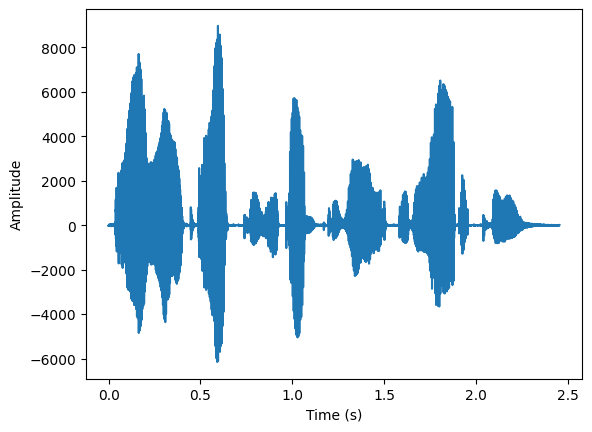

In [41]:
arr_0 = zipped_wav_to_array(parsed_0['wav_filename'])
start = parsed_0['timestamped_phonemes'][0][2]
arr_0 = arr_0[int(start * 16000):]
audio_array_to_wav_file(arr_0, '../data/TIMIT_sample_0.wav')
time = np.arange(0, len(arr_0)) / 16000
plt.plot(time, arr_0)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [42]:
phonemic_transcription = "".join(map(lambda x: x[0], parsed_0['timestamped_phonemes']))
print(phonemic_transcription)

ðɨaɪɹeɪtʔækɚstɑmpəweɪʔɨɾiɑɾɨkli


In [22]:
def files_to_df(files):
    records = []
    for filename in files:
        parsed = timit_file_to_dict(filename)
        parsed['audio'] = zipped_wav_to_array(parsed['wav_filename'])
        del parsed['wav_filename']
        parsed['phonemes'] = [phoneme for phoneme, _, _ in parsed['timestamped_phonemes']]
        parsed['phoneme_starts'] = [start for _, start, _ in parsed['timestamped_phonemes']]
        parsed['phoneme_ends'] = [end for _, _, end in parsed['timestamped_phonemes']]
        del parsed['timestamped_phonemes']
        parsed['words'] = [word for word, _, _ in parsed['timestamped_words']]
        parsed['word_starts'] = [start for _, start, _ in parsed['timestamped_words']]
        parsed['word_ends'] = [end for _, _, end in parsed['timestamped_words']]
        del parsed['timestamped_words']
        records.append(parsed)
    df = pd.DataFrame(records)
    return df.merge(speaker_info_df, on='speaker_initials', how='left')

In [23]:
train_df = files_to_df(training_files)
train_df.head()

,speaker_initials,transcription,transcription_start,transcription_end,audio,phonemes,phoneme_starts,phoneme_ends,words,word_starts,word_ends,sex,dialect_region,use,recording_date,birth_date,height,race,education_level,comments
0,LJD0,The irate actor stomped away idiotically.,0.0,4.1268,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, ð, ɨ, aɪ, ɹ, eɪ, t, ʔ, æ, k, , ɚ, s, t, , ɑ...","[0.0, 0.2501, 0.2661, 0.3592, 0.5472, 0.66, 0....","[0.2501, 0.2661, 0.3592, 0.5472, 0.66, 0.848, ...","[the, irate, actor, stomped, away, idiotically]","[0.2501, 0.3592, 0.9107, 1.532, 2.152, 2.7488]","[0.3592, 0.9107, 1.532, 2.152, 2.62, 3.7973]",F,North Midland,Train,03/19/86,03/06/61,"5'06""",WHT,BS,
1,RJH0,"If you do, go to it.",0.0,3.3792,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, h, ɪ, f, j, ʉ, d, , ʉ, u, , , oʊ, t, , u, ɨ...","[0.0, 0.227, 0.2577, 0.34, 0.516, 0.6015, 0.7,...","[0.227, 0.2577, 0.34, 0.516, 0.6015, 0.7, 0.81...","[if, you, do, go, to, it]","[0.227, 0.516, 0.7, 2.1848, 2.412, 2.7864]","[0.516, 0.7, 1.364, 2.412, 2.7864, 3.164]",M,Northern,Train,03/20/86,02/19/44,"5'09""",WHT,PHD,SOME
2,TXS0,"As coauthors, we presented our new book to the...",0.0,6.7175,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, ʔ, ɛ, z, k, , oʊ, w, ɔ, θ, ɪ, z, , w, ɨ, p,...","[0.0, 0.228, 0.2892, 0.386, 0.4925, 0.5406, 0....","[0.228, 0.2892, 0.386, 0.4925, 0.5406, 0.7, 0....","[as, coauthors, we, presented, our, new, book,...","[0.228, 0.4925, 1.8123, 1.972, 2.824, 3.04, 3....","[0.4925, 1.754, 1.972, 2.824, 3.04, 3.3907, 4....",M,New York City,Train,04/29/86,02/29/56,"6'0""",WHT,AS,
3,HIT0,A connoisseur will enjoy this shellfish dish.,0.0,4.9664,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, ʔ, ʌ, k, , ɑ, n, ɨ, s, u, ɚ, w, ə, l, ɨ, n,...","[0.0, 0.252, 0.3222, 0.388, 0.47, 0.543, 0.724...","[0.252, 0.3222, 0.388, 0.47, 0.543, 0.724, 0.7...","[a, connoisseur, will, enjoy, this, shellfish,...","[0.252, 0.388, 1.4328, 1.7671, 2.4222, 3.1312,...","[0.388, 1.4328, 1.7671, 2.4222, 2.9994, 4.079,...",M,Southern,Train,04/09/86,01/02/59,"5'9""",BLK,BS,
4,SEM1,An area sheltered from strong winds may be hig...,0.0,10.9876,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, ʔ, æ, n, ɨ, ʔ, ɛ, ɹ, i, ɨ, ʃ, ɛ, l, t, , ɚ,...","[0.0, 0.204, 0.2648, 0.3898, 0.4957, 0.548, 0....","[0.204, 0.2648, 0.3898, 0.4957, 0.548, 0.6648,...","[an, area, sheltered, from, strong, winds, may...","[0.204, 0.4957, 1.306, 2.1186, 2.501, 3.188, 4...","[0.4957, 1.306, 2.1186, 2.4, 3.188, 4.029, 4.4...",M,Southern,Train,03/06/86,02/12/47,"6'0""",WHT,PHD,"ARTICLULATE,"


In [ ]:
train_ds = Dataset.from_pandas(train_df)
print(train_ds[0])

In [25]:
test_df = files_to_df(test_files)
test_df.head()

,speaker_initials,transcription,transcription_start,transcription_end,audio,phonemes,phoneme_starts,phoneme_ends,words,word_starts,word_ends,sex,dialect_region,use,recording_date,birth_date,height,race,education_level,comments
0,GJF0,Kindergarten children decorate their classroom...,0.0,5.8573,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, , ɪ, n, ɚ, g, ɑ, ɹ, d, n̩, t, tʃ, ɪ, l, d, ...","[0.596, 0.804, 0.9, 0.964, 1.028, 1.124, 1.172...","[0.804, 0.9, 0.964, 1.028, 1.124, 1.172, 1.353...","[kindergarten, children, decorate, their, clas...","[0.804, 1.5707, 2.228, 2.948, 3.084, 4.1524, 4...","[1.5707, 2.228, 2.948, 3.084, 4.1524, 4.364, 4...",M,North Midland,Test,02/11/86,08/16/50,"5'11""",WHT,MS,
1,WBT0,The causeway ended abruptly at the shore.,0.0,5.0074,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, ð, ɨ, k, , ɔ, z, , w, eɪ, ɪ, n, d, , ɨ, d, ...","[0.0, 0.228, 0.2565, 0.3289, 0.428, 0.547, 0.9...","[0.228, 0.2565, 0.3289, 0.428, 0.547, 0.9, 0.9...","[the, causeway, ended, abruptly, at, the, shore]","[0.228, 0.3289, 1.4621, 1.921, 3.3963, 3.742, ...","[0.3289, 1.4621, 1.921, 3.124, 3.742, 3.862, 4...",M,New England,Test,03/26/86,05/24/34,"6'00""",WHT,BS,
2,TAS1,Her right hand aches whenever the barometric p...,0.0,6.4615,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, h, ɚ, ɹ, aɪ, t, h, æ, n, d, , , eɪ, k, , s,...","[0.0, 0.208, 0.3, 0.4093, 0.516, 0.796, 0.844,...","[0.208, 0.3, 0.4093, 0.516, 0.796, 0.844, 1.06...","[her, right, hand, aches, whenever, the, barom...","[0.208, 0.4093, 0.844, 1.896, 2.992, 3.548, 3....","[0.4093, 0.844, 1.656, 2.589, 3.548, 3.7, 4.80...",M,Northern,Test,03/12/86,04/22/57,"5'11""",WHT,HS,
3,KLT0,My own experience has followed simpler lines.,0.0,3.9629,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, m, ɑ, oʊ, n, ɨ, k, , s, p, , ɪ, ɝ, n, s, ɨ,...","[0.0, 0.3242, 0.3819, 0.5639, 0.7394, 0.8146, ...","[0.3242, 0.3819, 0.5639, 0.7394, 0.8146, 0.9, ...","[my, own, experience, has, followed, simpler, ...","[0.3242, 0.5639, 0.8146, 1.6204, 1.808, 2.2998...","[0.5639, 0.8146, 1.6204, 1.808, 2.2998, 2.932,...",M,Southern,Test,02/03/86,06/13/62,"5'11""",WHT,BS,
4,MLD0,Only lawyers love millionaires.,0.0,3.0516,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, oʊ, n, l, ɪ, l, ɔɪ, ɝ, z, l, ʌ, v, m, ɪ, j,...","[0.0, 0.22, 0.404, 0.532, 0.5746, 0.66, 0.78, ...","[0.22, 0.404, 0.532, 0.5746, 0.66, 0.78, 1.081...","[only, lawyers, love, millionaires]","[0.22, 0.66, 1.4604, 1.784]","[0.66, 1.4604, 1.784, 2.844]",F,Army Brat (moved around),Test,03/26/86,08/17/60,"5'02""",WHT,MS,FLEMISH


In [ ]:
test_ds = Dataset.from_pandas(test_df)
print(test_ds[0])